In [118]:
import os
import math
import tempfile
import torch

# Third Party
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import numpy as np
import pandas as pd

# First Party
#from tsfm.notebooks.hfdemo.tinytimemixer.utils import (
#    count_parameters,
#    get_data,
#    plot_preds,
#)

# Local
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.callbacks import TrackingCallback


import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [119]:
# 1. prepare data
data0 = pd.read_csv("hourly_clusters.csv")[['time', '0']]
data0['time'] = pd.to_datetime(data0['time'])
data0['0'] = (data0['0'] - data0['0'].mean()) / data0['0'].std()

In [120]:
# 2. get model
model = TinyTimeMixerForPrediction.from_pretrained("ibm/TTM", prediction_length=96)
model.eval()

TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=64, out_features=192, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0-1): 2 x TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=32, out_features=64, bias=True)
                    (dropout1): Dropout(p=0.2, inplace=False)
                    (fc2): Linear(in_features=64, out_features=32, bias=True)
                    (dropout2): Dropout(p=0.2, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
              

In [121]:
# 3. extract embeddings
def extract_2d_embeddings(target, seq_length=512, stride=128):
    embeddings = []
    for i in range(0, len(target) - seq_length + 1, stride):
        window = target[i:i+seq_length]
        inputs = torch.tensor(window).float().reshape(1, seq_length, 1)
        with torch.no_grad():
            outputs = model(inputs, output_hidden_states=True)
            # 关键修改：展平所有特征
            embedding = outputs.hidden_states[-1].flatten().numpy()  # 展平为1D
            embeddings.append(embedding)
    
    # 显式转换为二维并检查
    embeddings = np.array(embeddings)
    if embeddings.ndim > 2:
        embeddings = embeddings.reshape(embeddings.shape[0], -1)
    print("最终嵌入矩阵形状:", embeddings.shape)  # 应为 (n_samples, n_features)
    return embeddings

In [122]:
target = data0['0'].values.astype(np.float32)
embeddings = extract_2d_embeddings(target)

if np.isnan(embeddings).any():
    print("发现NaN值，正在处理...")
    embeddings = np.nan_to_num(embeddings)

最终嵌入矩阵形状: (202, 1024)


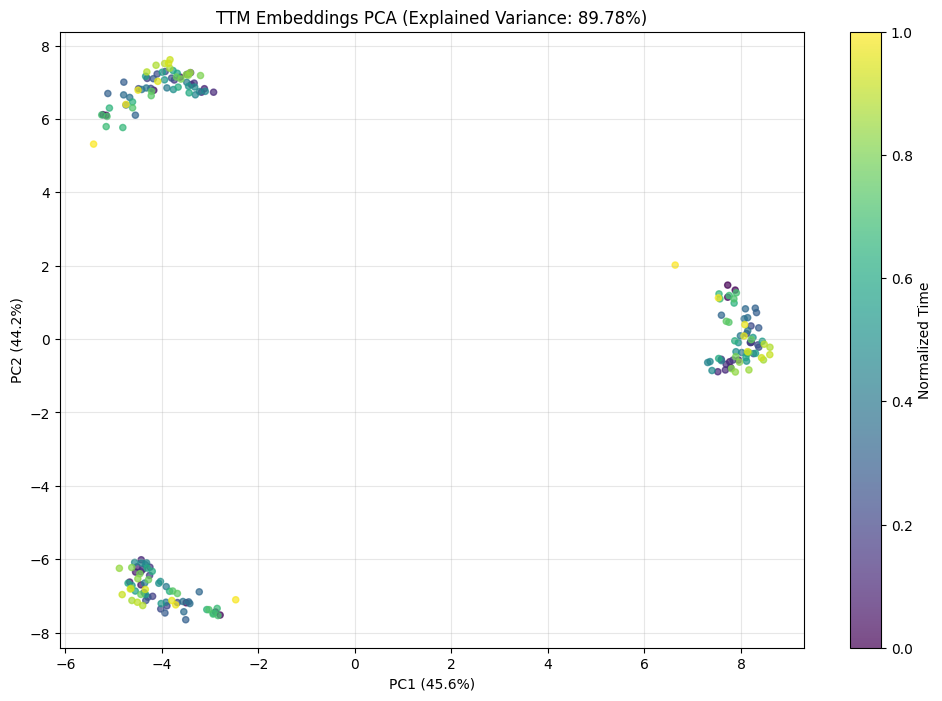

In [125]:
# 4. PCA
pca = PCA(n_components=2)
components = pca.fit_transform(embeddings)

plt.figure(figsize=(12, 8))
plt.scatter(
    components[:, 0], components[:, 1],
    c=np.linspace(0, 1, len(components)),  # 颜色表示时间顺序
    cmap='viridis',
    alpha=0.7,
    s=20
)
plt.colorbar(label="Normalized Time")
plt.title(f"TTM Embeddings PCA (Explained Variance: {pca.explained_variance_ratio_.sum():.2%})")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
plt.grid(alpha=0.3)
plt.show()

输入嵌入矩阵形状: (202, 1024)
[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 202 samples in 0.000s...
[t-SNE] Computed neighbors for 202 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 202 / 202
[t-SNE] Mean sigma: 1.247812
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.276268


/opt/anaconda3/envs/ttm_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.415072
t-SNE降维完成！KL散度: 0.41507190465927124


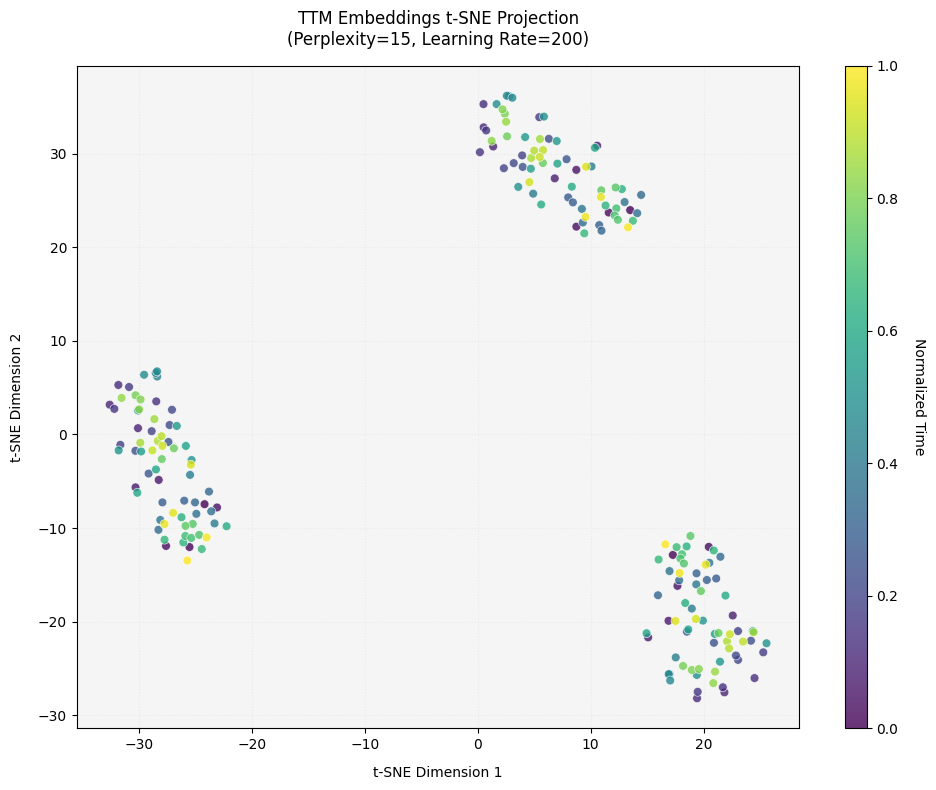

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 1. 输入数据检查
print(f"输入嵌入矩阵形状: {embeddings.shape}")  # 确认是 (202, 1024)

# 2. t-SNE降维参数优化（小数据集专用配置）
tsne = TSNE(
    n_components=2,
    perplexity=15,           # 对于202个样本，建议5-20
    early_exaggeration=12,
    learning_rate=200,       # 小数据集适用较高学习率
    n_iter=1000,
    random_state=42,
    init='pca',             # 用PCA初始化保证稳定性
    verbose=1               # 显示优化过程
)

# 3. 执行降维
components = tsne.fit_transform(embeddings)
print("t-SNE降维完成！KL散度:", tsne.kl_divergence_)

# 4. 可视化优化版
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    components[:, 0], components[:, 1],
    c=np.linspace(0, 1, len(components)),
    cmap='viridis',
    alpha=0.8,
    s=40,
    edgecolor='w',
    linewidths=0.5
)

# 添加美学元素
cbar = plt.colorbar(scatter, aspect=30)
cbar.set_label("Normalized Time", rotation=270, labelpad=20)
plt.title("TTM Embeddings t-SNE Projection\n(Perplexity=15, Learning Rate=200)", pad=15)

# 坐标轴调整
plt.xlabel("t-SNE Dimension 1", labelpad=10)
plt.ylabel("t-SNE Dimension 2", labelpad=10)
plt.grid(alpha=0.15, linestyle=':')

# 设置背景色（修正错误）
ax = plt.gca()
ax.set_facecolor('#f5f5f5')  # 浅灰色背景

# 显示图形
plt.tight_layout()
plt.show()

In [ ]:
# There are three stable states?
# cycle?

In [143]:
data0

,time,0
0,2012-01-01 00:00:00,-1.652485
1,2012-01-01 01:00:00,-0.065644
2,2012-01-01 02:00:00,-0.307963
3,2012-01-01 03:00:00,-0.700096
4,2012-01-01 04:00:00,-0.928357
...,...,...
26299,2014-12-31 19:00:00,1.570302
26300,2014-12-31 20:00:00,0.561953
26301,2014-12-31 21:00:00,0.091516
26302,2014-12-31 22:00:00,0.795255


In [152]:
import numpy as np
from datasets import Dataset
from transformers import Trainer, TrainingArguments

def dataframe_direct_eval(
    dataframe,
    batch_size=32,
    context_length=512,
    forecast_length=96
):
    """
    终极修正版 - 确保正确的3D输入形状
    参数:
        dataframe: 只需要包含两列 ['time', '0'] 的DataFrame
    """
    # 1. 提取数据并转换为正确的3D形状
    ts_values = dataframe['0'].values.astype(np.float32)
    
    # 关键修正：添加batch维度和channel维度
    past_values = ts_values[:context_length].reshape(1, -1, 1)  # 形状 (1, context_length, 1)
    future_values = ts_values[context_length:context_length+forecast_length].reshape(1, -1, 1)
    
    # 2. 创建数据集
    eval_dataset = Dataset.from_dict({
        "past_values": past_values,
        "future_values": future_values
    })
    
    # 3. 加载模型
    model = TinyTimeMixerForPrediction.from_pretrained("ibm/TTM", revision="main")
    
    # 4. 评估配置
    trainer = Trainer(
        model=model,
        args=TrainingArguments(
            output_dir="./tmp",
            per_device_eval_batch_size=batch_size,
            remove_unused_columns=False
        )
    )
    
    # 5. 执行评估
    print("🔥 正在执行终极版评估...")
    results = trainer.evaluate(eval_dataset)
    print("✅ 评估结果:", results)
    return results

# 使用示例
results = dataframe_direct_eval(data0)

🔥 正在执行终极版评估...


✅ 评估结果: {'eval_loss': 0.06849510967731476, 'eval_model_preparation_time': 0.0009, 'eval_runtime': 0.0399, 'eval_samples_per_second': 25.05, 'eval_steps_per_second': 25.05}
